In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks

from astropy.io import fits
from astropy import units as u
from astropy.time import Time
from astropy.table import Table, join, vstack
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import aggregate_downsample

import lightcurve # This works for numpy 1.23.0(or earlier)
print('Numpy version', np.version.version)

os.environ['lref'] = '/grp/hst/cdbs/lref/'

/Users/willyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Numpy version 1.23.0


In [2]:
# =============
# Read HST Data
# =============

# Select object
object_name = 'ZTF_J2252_0519'
'''
Select from:
1. YZ_LMi
2. ASASSN_14mv
3. GP_Com
4. ASASSN_14cn
5. ZTF_J2252_0519
'''
data_path = '../HST_DATA/'+object_name+'/'


'''
lc1 = lightcurve.read(data_path+'leqk41vnq_corrtag_a.fits')
print(lc1)
# Print every line
print(lc1.colnames)
for i, k in enumerate(lc1):
    print (i,k['mjd'], k['flux'], k['flux_error'])
'''
#corrtag = Table.read(data_path+'leqk41vnq_corrtag_a.fits')
#corrtag

"\nlc1 = lightcurve.read(data_path+'leqk41vnq_corrtag_a.fits')\nprint(lc1)\n# Print every line\nprint(lc1.colnames)\nfor i, k in enumerate(lc1):\n    print (i,k['mjd'], k['flux'], k['flux_error'])\n"

### Generate original lightcurve

Data directroy: ../HST_DATA/ZTF_J2252_0519 
 Number of orbits: 5 

Segment A fluxcal
 using unity flux calibration instead.
 using unity TDS correction instead.
 using unity flux calibration instead.
 using unity TDS correction instead.
dataset        times        ...        net         signal_to_noise
------- ------------------- ... ------------------ ---------------
    1.0 0.03200000151991844 ...  24.34653663635254       4.9343977
    1.0  1.0320000015199184 ... 25.524784088134766       5.0523715
    1.0  2.0320000015199184 ...  19.83895492553711        4.454094
    1.0  3.0320000015199184 ...  28.52606201171875       5.3409796
    1.0   4.032000001519918 ... 26.922367095947266        5.195787
    1.0   5.032000001519918 ...  29.48586082458496       5.4308033
    1.0   6.032000001519918 ... 19.444849014282227       4.4106975
    1.0   7.032000001519918 ... 28.790740966796875        5.366914
    1.0   8.032000001519918 ...  22.43737030029297       4.7371163
    1.0   9.03200000151991

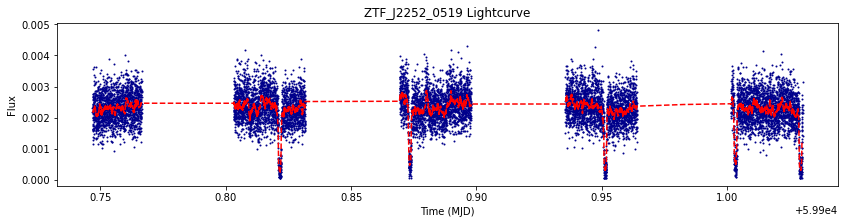

In [3]:
# ===================
# Generate Lightcurve
# ===================
plt.figure(figsize=(14, 3))

data_dir = Path('../HST_DATA/'+object_name+'/')
corrtag_files = sorted(glob.glob(str(data_dir/'*corrtag*.fits')))
print('Data directroy:', data_dir, '\n', 
      'Number of orbits:', len(corrtag_files), '\n')

lc_concat = lightcurve.read(corrtag_files[0])
print(lc_concat)
for i in range(len(corrtag_files)-1):
    print(corrtag_files[i+1])
    lc = lightcurve.read(corrtag_files[i+1])
    lc_concat = np.concatenate((lc_concat, lc))
# Getting rid of empty lines
lc_concat = lc_concat[np.where(lc_concat['flux'] > 0)]

# Computing Running Median
win = 50
lc_df = pd.DataFrame(lc_concat)
lc_median = lc_df.rolling(window=win).median()
lc_median = lc_median[win:]

plt.plot(lc_concat['mjd'], lc_concat['flux'], '.', c='darkblue', ms=2)
plt.plot(lc_median['mjd'], lc_median['flux'], c='r', ls='--')
#plt.xlim(59824.019674-1e-4, 59824.019674+1e-4)
plt.xlabel('Time (MJD)')
plt.ylabel('Flux')
plt.title(object_name+' Lightcurve')
plt.show()

In [5]:
# Save Lightcurve in textfile
mjd        = lc_concat['mjd']
flux       = lc_concat['flux']
flux_error = lc_concat['flux_error']
zeros      = np.zeros(len(mjd))
ones       = np.ones(len(mjd))
exp        = np.ones(len(mjd)) / 86400 # exposure time for individual data point

# MJD to BJD correction
from astropy import time, coordinates as coord, units as u
obj_location = coord.SkyCoord("16:11:33.9749", "+63:08:31.8836", 
                              unit=(u.hourangle, u.deg), frame='icrs')
site_location = coord.EarthLocation.of_site('Greenwich') # <===== Needs a site location, placeholder
times = time.Time(lc_concat['mjd'], format='mjd', scale='utc', 
                  location=coord.EarthLocation.of_site('Greenwich'))  
ltt_bary = times.light_travel_time(obj_location)  
bjd = times.tdb + ltt_bary

# Write arrays in txt file
header = "BJD EXP FLUX FLUX_ERROR ONES ONES"
orig_file_name  = str(object_name + '_lc.txt')
print('file save as:', orig_file_name, '\n')
with open(orig_file_name, 'w') as f: 
    f.write(header + "\n")
    for bjd,exp,flux,flux_error,zeros,ones in zip(
        bjd,exp,flux,flux_error,zeros,ones): 
        f.write(f"{bjd} {exp} {flux} {flux_error} {ones} {ones}\n")

file save as: ZTF_J2252_0519_lc.txt 



### Making eclipsed lightcurve

Segment A fluxcal
 using unity flux calibration instead.
 using unity TDS correction instead.
 using unity flux calibration instead.
 using unity TDS correction instead.
MJD Time: 59900.7468 -- 59900.7665 | EXP Time: 0.032 -- 1698.032


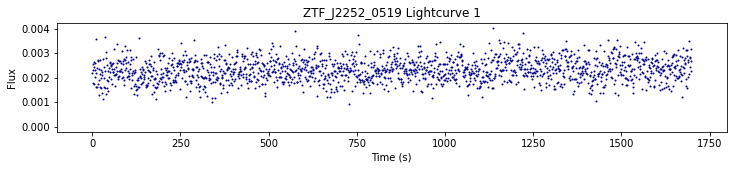

Segment A fluxcal
 using unity flux calibration instead.
 using unity TDS correction instead.
 using unity flux calibration instead.
 using unity TDS correction instead.
MJD Time: 59900.8032 -- 59900.8317 | EXP Time: 0.032 -- 2465.032


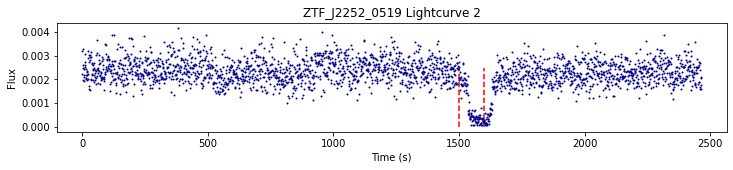

Segment A fluxcal
 using unity flux calibration instead.
 using unity TDS correction instead.
 using unity flux calibration instead.
 using unity TDS correction instead.
MJD Time: 59900.8693 -- 59900.8978 | EXP Time: 0.032 -- 2465.032


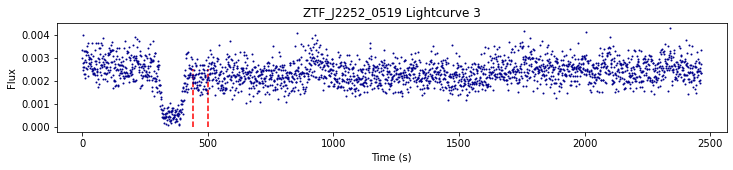

Segment A fluxcal
 using unity flux calibration instead.
 using unity TDS correction instead.
 using unity flux calibration instead.
 using unity TDS correction instead.
MJD Time: 59900.9354 -- 59900.964 | EXP Time: 0.0 -- 2465.0


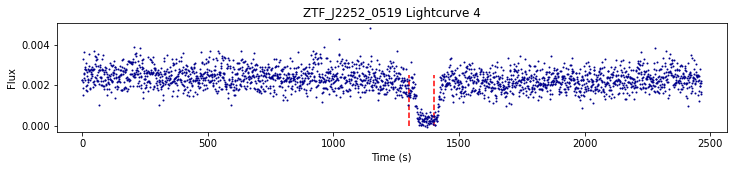

Segment A fluxcal
 using unity flux calibration instead.
 using unity TDS correction instead.
 using unity flux calibration instead.
 using unity TDS correction instead.
MJD Time: 59901.0016 -- 59901.0301 | EXP Time: 0.0 -- 2465.0


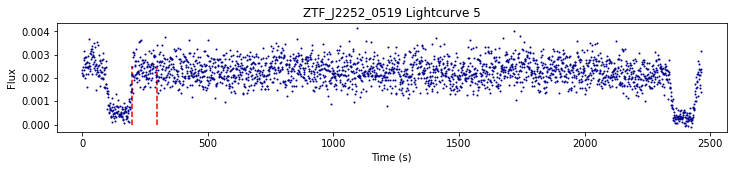

Time: 59901.00158775 -- 59901.0301179065
Segment A fluxcal
 using unity flux calibration instead.
 using unity TDS correction instead.
 using unity flux calibration instead.
 using unity TDS correction instead.
Segment A fluxcal
 using unity flux calibration instead.
 using unity TDS correction instead.
 using unity flux calibration instead.
 using unity TDS correction instead.
Segment A fluxcal
 using unity flux calibration instead.
 using unity TDS correction instead.
 using unity flux calibration instead.
 using unity TDS correction instead.
Segment A fluxcal
 using unity flux calibration instead.
 using unity TDS correction instead.
 using unity flux calibration instead.
 using unity TDS correction instead.
Segment A fluxcal
 using unity flux calibration instead.
 using unity TDS correction instead.
 using unity flux calibration instead.
 using unity TDS correction instead.


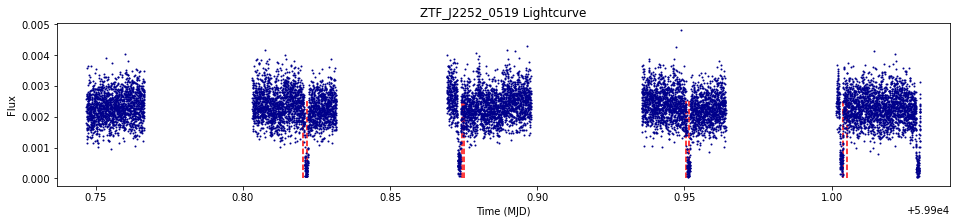

In [6]:
# =========================================
# Cut eclipsing data by hand
# Try to use the other method(by magnitude) 
# for easier processing
# =========================================
day_to_s = 24*60*60
corrtag_files = sorted(glob.glob(str(data_dir/'*corrtag*.fits')))

eclps_exp = [[1e6,  1e6], # <===== No eclipse 
             [1500, 1600],   
             [440,  500],   
             [1300, 1400], 
             [200,  300]]

for i in range(len(corrtag_files)):
    lc = lightcurve.read(corrtag_files[i])
    print('MJD Time:', round(np.min(lc['mjd']), 4), '--', round(np.max(lc['mjd']), 4), '|',
          'EXP Time:', round(np.min(lc['times']), 4), '--', round(np.max(lc['times']), 4))
    plt.figure(figsize=(12, 2))
    plt.plot(lc['times'], lc['flux'], '.', color='darkblue', markersize=2)
    plt.vlines(x=eclps_exp[i][0], ymin=0, ymax=2.5e-3, colors='r', linestyle='--')
    plt.vlines(x=eclps_exp[i][1], ymin=0, ymax=2.5e-3, colors='r', linestyle='--')
    plt.xlim(np.min(lc['times'])-1e2, np.max(lc['times'])+1e2)
    plt.xlabel('Time (s)')
    plt.ylabel('Flux')
    plt.title(object_name+' Lightcurve '+str(i+1))
    plt.show()

# Total Lightcurve
lc_tot = lc_concat #<======= Enter corresponding lightcurve
print('Time:', np.min(lc['mjd']), '--', np.max(lc['mjd']))
plt.figure(figsize=(16, 3))

for i in range(len(corrtag_files)):
    lc = lightcurve.read(corrtag_files[i])
    
    plt.vlines(x=eclps_exp[i][0]/day_to_s+np.min(lc['mjd']), 
               ymin=0, ymax=2.5e-3, colors='r', linestyle='--')
    plt.vlines(x=eclps_exp[i][1]/day_to_s+np.min(lc['mjd']), 
               ymin=0, ymax=2.5e-3, colors='r', linestyle='--')

plt.xlim(np.min(lc_tot['mjd'])-1e-2, np.max(lc_tot['mjd'])+1e-2)
plt.plot(lc_tot['mjd'], lc_tot['flux'], '.', color='darkblue', markersize=2)
plt.xlabel('Time (MJD)')
plt.ylabel('Flux')
plt.title(object_name+' Lightcurve')
plt.show()

Number of peaks: 4
3305    59900.821848
4550    59900.873839
7981    59900.951144
9263    59901.003609
Name: BJD, dtype: float64


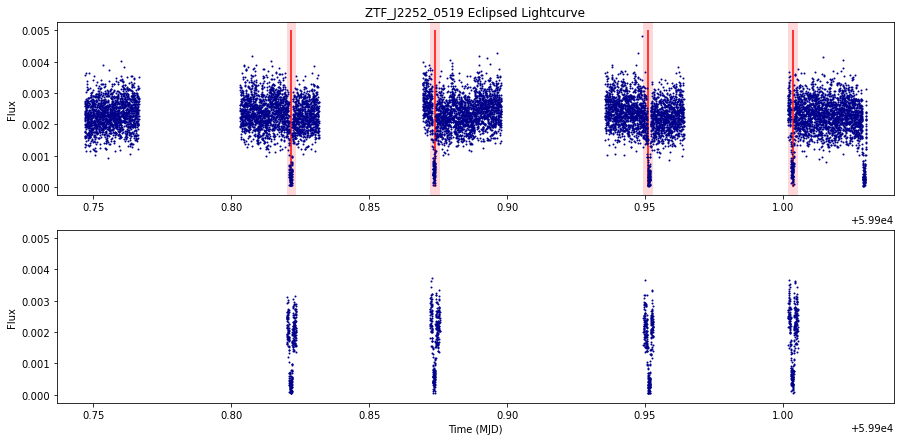

In [7]:
# ===============================
# Cut eclipsing data by magnitude
# ===============================
from scipy.signal import find_peaks

# Read saved file        
lc_orig = pd.read_csv(orig_file_name, sep=" ")

# Find the peaks in the flux data
pro = 0.0035            # <========== Adjust prominence!
flux = -1*lc_orig['FLUX']
peaks, _ = find_peaks(flux, prominence = pro, height=(None, 0))
print('Number of peaks:', len(peaks))
print(lc_orig['BJD'][peaks])

# Select eclipsing regions
indices = lc_orig.index.values
eclp_regions = []
win = 150               # <========== Adjust cutting window width!
for peak in peaks:
    eclp_region = indices[np.where((indices >= peak-win) & (indices <= peak+win))]
    eclp_regions.append(eclp_region)

# Plot eclipsed lightcurve
f, axs = plt.subplots(2, 1, figsize=(15,7), sharey=True)
bdr = 1e-2

# Plot the peaks
axs[0].plot(lc_orig['BJD'], lc_orig['FLUX'], '.', c='darkblue', ms=2)
axs[0].vlines(x=lc_orig['BJD'][peaks], ymin=0, ymax=0.005, color='r', ls='-')
for region in eclp_regions:
    axs[0].axvspan(lc_orig['BJD'][region[0]], lc_orig['BJD'][region[-1]], 
               color='r', alpha=0.15, lw=0)

# Plot the cutted lightcurve
eclp_regions = np.array(eclp_regions).flatten()
lc_eclp = lc_orig.loc[eclp_regions]
axs[1].plot(lc_eclp['BJD'], lc_eclp['FLUX'], '.', c='darkblue', ms=2)

axs[0].set_xlim(np.min(lc_orig['BJD']-bdr), np.max(lc_orig['BJD'])+bdr)
axs[1].set_xlim(np.min(lc_orig['BJD']-bdr), np.max(lc_orig['BJD'])+bdr)
axs[0].set_ylabel('Flux')
axs[1].set_ylabel('Flux')
axs[1].set_xlabel('Time (MJD)')
axs[0].set_title(object_name+' Eclipsed Lightcurve')
plt.show()

In [8]:
# Save Eclipsed lightcurve
bjd        = lc_eclp['BJD']
flux       = lc_eclp['FLUX']
flux_error = lc_eclp['FLUX_ERROR']
zeros      = np.zeros(len(bjd))
ones       = np.ones(len(bjd))
exp        = np.ones(len(bjd)) / 86400 # exposure time for individual data point

# Write arrays in txt file
header = "BJD EXP FLUX FLUX_ERROR ONES ONES"
eclp_file_name  = str(object_name + '_lc_eclp.txt')
print('file save as:', eclp_file_name, '\n')
with open(eclp_file_name, 'w') as f: 
    f.write(header + "\n")
    for bjd,exp,flux,flux_error,ones,ones in zip(
        bjd,exp,flux,flux_error,ones,ones): 
        f.write(f"{bjd} {exp} {flux} {flux_error} {ones} {ones}\n")

file save as: ZTF_J2252_0519_lc_eclp.txt 



### Binning the lightcurve

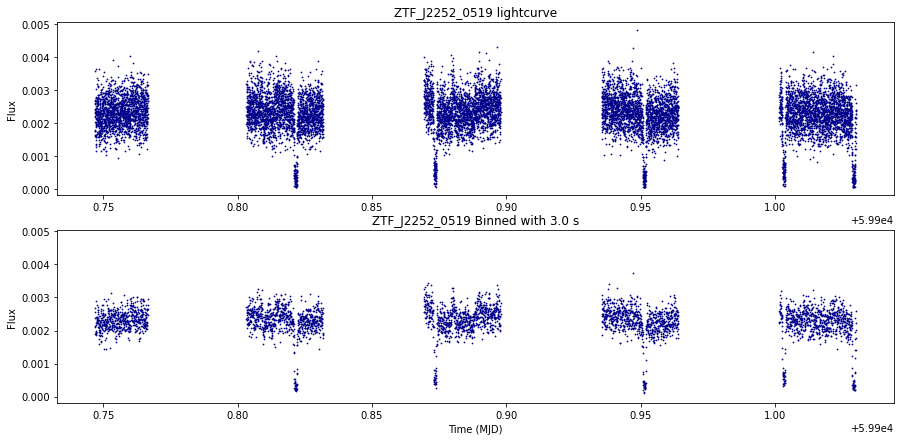

In [9]:
from astropy import units as u
from astropy.time import Time
from astropy.table import Table, join, vstack
from astropy.timeseries import TimeSeries
from astropy.timeseries import aggregate_downsample

# Put original lightcurve into an Astropy TimeSeries
orig_file_name = str(object_name + '_lc.txt')
lc_orig = Table.read(orig_file_name, format='ascii')
ts_orig = TimeSeries(data=lc_orig, time=Time(lc_orig['BJD'], format='mjd'))

# Bin the lightcurve
bin_size = 3 * u.second
ts_bin = aggregate_downsample(ts_orig, time_bin_size=bin_size)

# Plot the original and binned lightcurve
f, axs = plt.subplots(2, 1, figsize=(15,7), sharey=True)
axs[0].plot(ts_orig['BJD'], ts_orig['FLUX'], '.', color='darkblue', markersize=1.5)
axs[1].plot(ts_bin['BJD'], ts_bin['FLUX'], '.', color='darkblue', markersize=1.5)

#eclp_time = 59900.821848; wid = 5e-3
#axs[0].set_xlim(eclp_time-wid, eclp_time+wid)
#axs[1].set_xlim(eclp_time-wid, eclp_time+wid)

axs[0].set_title(object_name+' lightcurve')
axs[1].set_title(object_name+' Binned with '+str(bin_size))
axs[1].set_xlabel('Time (MJD)')
axs[0].set_ylabel('Flux')
axs[1].set_ylabel('Flux')
plt.show()

In [10]:
# Save Binned lightcurve
bjd        = ts_bin['BJD'].value
flux       = ts_bin['FLUX'].value
flux_error = ts_bin['FLUX_ERROR'].value
zeros      = np.zeros(len(bjd))
ones       = np.ones(len(bjd))
exp        = np.ones(len(bjd)) / 86400 # exposure time for individual data point

# Write arrays in txt file
header = "BJD EXP FLUX FLUX_ERROR ONES ONES"
bin_file_name  = str(object_name + '_lc_bin.txt')
print('file save as:', bin_file_name, '\n')
with open(bin_file_name, 'w') as f: 
    f.write(header + "\n")
    for bjd,exp,flux,flux_error,ones,ones in zip(
        bjd,exp,flux,flux_error,ones,ones): 
        f.write(f"{bjd} {exp} {flux} {flux_error} {ones} {ones}\n")

file save as: ZTF_J2252_0519_lc_bin.txt 



### Lightcurve analysis

Periodogram results: 
 Period = 37.37591755905202 min 
 Peak in range (10, 20): 19.999016096898785 min 
 Transit time = 59900.76973992653


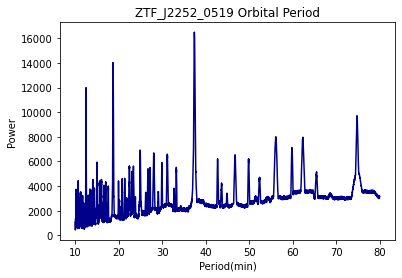

In [11]:
# ===================
# Lightcurve Analysis
# ===================
from astropy.timeseries import BoxLeastSquares

lc = Table.read(orig_file_name, format='ascii')

# Compute Orbital Period (Box Least Squares)
model = BoxLeastSquares(t  = lc['BJD']*u.day, 
                        y  = lc['FLUX'], 
                        dy = lc['FLUX_ERROR'])
periodogram = model.autopower(1/1440.*u.day,
                              minimum_period=10/1440.*u.day, 
                              maximum_period=80/1440.*u.day)

# Period & Transit_time
period_bls = periodogram.period[np.argmax(periodogram.power)]*1440/u.day*u.min
transit_time_bls = Time(periodogram.transit_time[np.argmax(periodogram.power)], format='mjd')

# Check other peaks
p_min = 10 # in min
p_max = 20 # in min
x = periodogram.period.value*1440
tmp = np.where((x > p_min) & (x < p_max))
print('Periodogram results:', '\n',
      'Period =', period_bls, '\n', 
      f'Peak in range {p_min, p_max}:', (np.max(x[tmp]))*u.min, '\n',
      'Transit time =', transit_time_bls)

# Converge to Period Frame
plt.plot(periodogram.period*1440, periodogram.power, color='darkblue')
plt.xlabel('Period(min)')
plt.ylabel('Power')
plt.title(object_name+' Orbital Period')
plt.show()

Enter lightcurve parameters: 
 Period: 37.37591755905202 min 
 Transit Time: 59900.76973992653


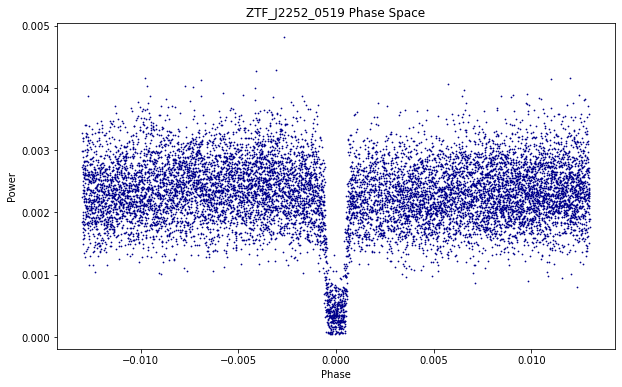

In [12]:
# ===================
# Plot in Phase Space
# ===================
ts = TimeSeries(data=lc, time=Time(lc['BJD'], format='mjd'))

period = period_bls                   # <========== Best period
transit_time = transit_time_bls       # <========== Best transit time
print('Enter lightcurve parameters:', '\n',
      'Period:', period, '\n',
      'Transit Time:', transit_time)

ts_folded = ts.fold(period=period, epoch_time=transit_time)

phase      = ts_folded.time.jd
flux       = ts_folded['FLUX']
flux_error = ts_folded['FLUX_ERROR']

plt.figure(figsize=(10, 6))
plt.plot(phase, flux, '.', color='darkblue', markersize=1.5)
plt.xlabel('Phase')
plt.ylabel('Power')
plt.title(object_name+' Phase Space')
plt.show()

In [13]:
# Save phase-folded lightcurve
phase      = phase
flux       = flux
flux_error = flux_error
zeros      = np.zeros(len(phase))
ones       = np.ones(len(phase))
exp        = np.ones(len(phase)) / 86400 # exposure time for individual data point

# Write arrays in txt file
header = "PHASE EXP FLUX FLUX_ERROR ONES ONES"
fold_file_name  = str(object_name + '_lc_fold.txt')
print('file save as:', fold_file_name, '\n')
with open(fold_file_name, 'w') as f: 
    f.write(header + "\n")
    for phase,exp,flux,flux_error,ones,ones in zip(
        phase,exp,flux,flux_error,ones,ones): 
        f.write(f"{phase} {exp} {flux} {flux_error} {ones} {ones}\n")

file save as: ZTF_J2252_0519_lc_fold.txt 



Period = 37.37591755905202 min


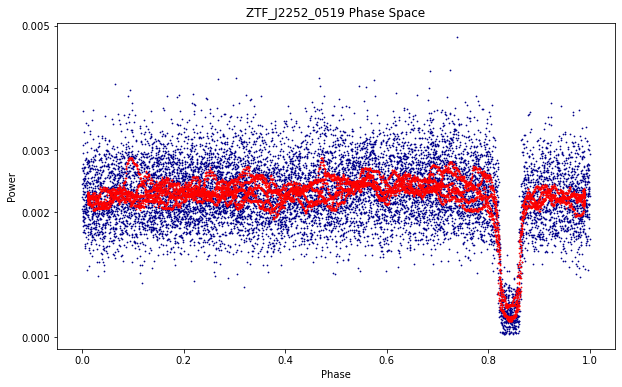

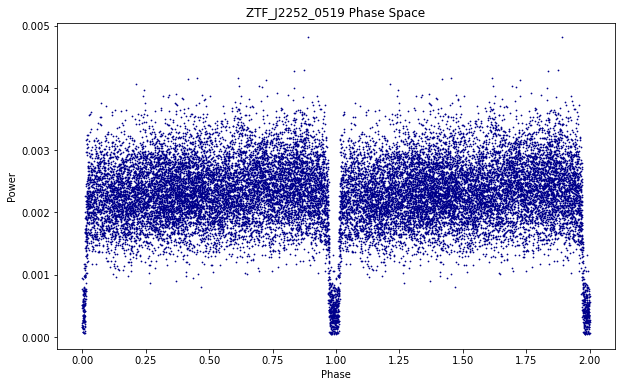

In [14]:
# =============================================
# Plot in Phase Space by hand (not recommended)
# =============================================
lc = pd.read_csv(orig_file_name, sep=" ")           # <==== Corresponding lightcurve file
p = period_bls; print('Period =', p)                # <==== Best period
t0 = 59900.821848                                   # <==== Best ephemeris t0

period = p/1440 /u.min*u.day
lc['phase'] = ((lc['BJD'])/period) % 1

win = 50
lc_med = lc.rolling(window=win).median()
lc_med = lc_med[win:]

plt.figure(figsize=(10, 6))
plt.plot(lc['phase'], lc['FLUX'], '.', color='darkblue', markersize=1.5)
plt.plot(lc_med['phase'], lc_med['FLUX'], 'r.', markersize=1.5)
plt.xlabel('Phase')
plt.ylabel('Power')
plt.title(object_name+' Phase Space')
plt.show()

# ==============================
# Adjust lightcurve to ephemeris
# ==============================
phase_0 = np.array(((lc['BJD']-t0)/period) % 1)
phase_0 = np.concatenate((phase_0, phase_0+1), axis=0)
flux_0 = np.concatenate((np.array(lc['FLUX']), np.array(lc['FLUX'])), axis=0)

plt.figure(figsize=(10, 6))
plt.plot(phase_0, flux_0, '.', color='darkblue', markersize=1.5)
plt.xlabel('Phase')
plt.ylabel('Power')
plt.title(object_name+' Phase Space')
plt.show()